In [2]:
from pathlib import Path

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from scipy.stats import friedmanchisquare

In [4]:
from lenskit import topn
from lenskit.metrics.predict import rmse

In [5]:
dataset = "ml100k"

In [6]:
in_dir = Path("output")

In [7]:
dirs = [fld for fld in in_dir.glob(f'{dataset}-*')]

In [8]:
recs = []
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = pd.read_csv(file, sep=',')
        rec["dataset"] = fld.name.split("-")[0]
        rec["algorithm"] = fld.name.split("-")[1]
        recs.append(rec)

recs = pd.concat(recs, ignore_index=True)
recs = recs.astype({'dataset': 'category', 'algorithm': 'category'})

In [9]:
preds = []
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = pd.read_csv(file, sep=',')
        pred["dataset"] = fld.name.split("-")[0]
        pred["algorithm"] = fld.name.split("-")[1]
        preds.append(pred)

preds = pd.concat(preds, ignore_index=True)

In [10]:
testSplitData = "splitData"

In [11]:
SplitData_dir = Path(testSplitData)
dirs = [fld for fld in SplitData_dir.glob(dataset)]

In [12]:
test = []
for fld in dirs:
    for file in fld.glob("test-*"):
        test.append(pd.read_csv(file, sep=','))

test = pd.concat(test, ignore_index=True)

In [13]:
rla = topn.RecListAnalysis()

rla.add_metric(topn.precision)
rla.add_metric(topn.recip_rank)
rla.add_metric(topn.ndcg)

results = rla.compute(recs, test)
results.head()

nrecs  precision  recip_rank      ndcg
user dataset algorithm                                        
1    ml100k  ALS        100.0       0.00    0.000000  0.000000
             IALS       100.0       0.01    0.010526  0.051368
             II         100.0       0.01    0.016393  0.056903
             UU         100.0       0.00    0.000000  0.000000
2    ml100k  ALS        100.0       0.02    0.062500  0.129815

In [14]:
def summarize(vals):
    summary = sms.DescrStatsW(vals)
    lo, hi = summary.tconfint_mean()
    return pd.Series({'mean': np.mean(vals), 'lower': lo, 'higher': hi})

In [15]:
stats = results.drop(columns=['nrecs']).stack().groupby(level=['algorithm', -1]).apply(summarize)
stats

algorithm                    
ALS        precision   mean      0.010594
                       lower     0.009917
                       higher    0.011271
           recip_rank  mean      0.072280
                       lower     0.060951
                       higher    0.083610
           ndcg        mean      0.080681
                       lower     0.074329
                       higher    0.087034
IALS       precision   mean      0.033701
                       lower     0.032895
                       higher    0.034507
           recip_rank  mean      0.201434
                       lower     0.184915
                       higher    0.217952
           ndcg        mean      0.256107
                       lower     0.245898
                       higher    0.266317
II         precision   mean      0.009024
                       lower     0.008385
                       higher    0.009664
           recip_rank  mean      0.039078
                       lower     0.032363
    

In [16]:
pltData = (results.drop(columns=['nrecs']).stack()).reset_index().drop(columns=['dataset'])
pltData.columns = ['user', 'algorithm','metric', 'val']

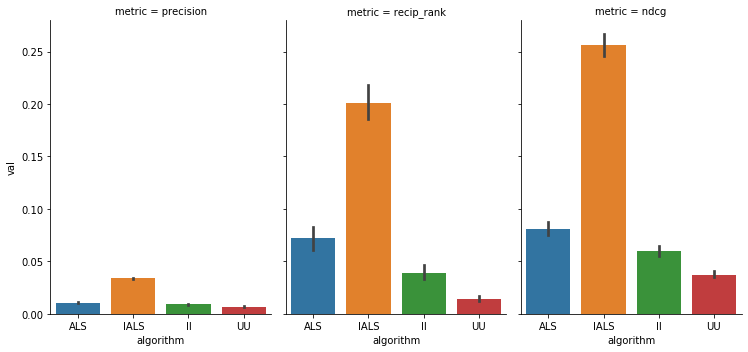

In [17]:
g = sns.catplot(x = "algorithm", y = "val", data = pltData, kind="bar", col = "metric", aspect=.7)

In [18]:
grp_data = results.drop(columns=['nrecs']).reset_index()

# ndcg   

#### Repeated Measures ANOVA

In [19]:
aovrm = AnovaRM(grp_data, 'ndcg', 'user', within=['algorithm'])
res = aovrm.fit()

print(res)

                  Anova
          F Value  Num DF   Den DF  Pr > F
------------------------------------------
algorithm 998.7848 3.0000 2826.0000 0.0000



#### Post Hoc analysis - Tukey's HSD

In [20]:
mc = MultiComparison(grp_data['ndcg'], grp_data['algorithm'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   ALS   IALS   0.1754 0.001  0.1631  0.1877   True
   ALS     II  -0.0209 0.001 -0.0332 -0.0086   True
   ALS     UU  -0.0432 0.001 -0.0556 -0.0309   True
  IALS     II  -0.1963 0.001 -0.2086  -0.184   True
  IALS     UU  -0.2187 0.001  -0.231 -0.2064   True
    II     UU  -0.0223 0.001 -0.0346   -0.01   True
---------------------------------------------------
['ALS' 'IALS' 'II' 'UU']


#### The Friedman test - nonparametric version of the repeated measures ANOVA

In [21]:
arg = []
for alg, data in grp_data.groupby("algorithm"):
    arg.append(data["ndcg"].to_numpy())
stat, p = friedmanchisquare(arg[0], arg[1], arg[2], arg[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1471.867, p=0.000


# precision   

#### Repeated Measures ANOVA

In [22]:
aovrm = AnovaRM(grp_data, 'precision', 'user', within=['algorithm'])
res = aovrm.fit()

print(res)

                   Anova
           F Value  Num DF   Den DF  Pr > F
-------------------------------------------
algorithm 1932.4292 3.0000 2826.0000 0.0000



#### Post Hoc analysis - Tukey's HSD

In [23]:
mc = MultiComparison(grp_data['precision'], grp_data['algorithm'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ALS   IALS   0.0231  0.001  0.0219  0.0243   True
   ALS     II  -0.0016 0.0064 -0.0028 -0.0003   True
   ALS     UU  -0.0038  0.001 -0.0051 -0.0026   True
  IALS     II  -0.0247  0.001 -0.0259 -0.0234   True
  IALS     UU  -0.0269  0.001 -0.0282 -0.0257   True
    II     UU  -0.0023  0.001 -0.0035  -0.001   True
----------------------------------------------------
['ALS' 'IALS' 'II' 'UU']


#### The Friedman test - nonparametric version of the repeated measures ANOVA

In [24]:
arg = []
for alg, data in grp_data.groupby("algorithm"):
    arg.append(data["precision"].to_numpy())
stat, p = friedmanchisquare(arg[0], arg[1], arg[2], arg[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1802.031, p=0.000


# recip_rank

#### Repeated Measures ANOVA

In [25]:
aovrm = AnovaRM(grp_data, 'recip_rank', 'user', within=['algorithm'])
res = aovrm.fit()

print(res)

                  Anova
          F Value  Num DF   Den DF  Pr > F
------------------------------------------
algorithm 245.0555 3.0000 2826.0000 0.0000



#### Post Hoc analysis - Tukey's HSD

In [26]:
mc = MultiComparison(grp_data['recip_rank'], grp_data['algorithm'])
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   ALS   IALS   0.1292  0.001  0.1094  0.1489   True
   ALS     II  -0.0332  0.001 -0.0529 -0.0135   True
   ALS     UU  -0.0578  0.001 -0.0775 -0.0381   True
  IALS     II  -0.1624  0.001 -0.1821 -0.1426   True
  IALS     UU   -0.187  0.001 -0.2067 -0.1672   True
    II     UU  -0.0246 0.0074 -0.0443 -0.0049   True
----------------------------------------------------
['ALS' 'IALS' 'II' 'UU']


#### The Friedman test - nonparametric version of the repeated measures ANOVA

In [27]:
arg = []
for alg, data in grp_data.groupby("algorithm"):
    arg.append(data["recip_rank"].to_numpy())
stat, p = friedmanchisquare(arg[0], arg[1], arg[2], arg[3])
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=1147.249, p=0.000
